# Problem Statement

Quantium's client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period. The Quantium analytics team are engaged in these processes to evaluate and analyse the performance of change and recommend whether it has been successful. 

# Objectives
The Quantium analytics team would need to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')
from statistics import stdev
import scipy.stats
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
cleaned_df = pd.read_csv(r"C:\Users\NG POOI LING\Desktop\Forage D.Analytics\Quantium\QVI_data.csv")
cleaned_df.columns = cleaned_df.columns.str.lower()
# Add a new month ID column in the data with the format yyyymm
cleaned_df.date = pd.to_datetime(cleaned_df.date)
cleaned_df['month'] = cleaned_df.date.dt.to_period('M')

In [3]:
# create the metrics of interest 
metrics_df = cleaned_df.groupby(['store_nbr','month']).agg({'tot_sales':'sum','lylty_card_nbr':'nunique','txn_id':'nunique','prod_qty':'sum'}).rename(columns={'tot_sales':'monthly_sales','lylty_card_nbr':'num_of_customers','txn_id':'num_of_txn'})
# transactions per customer
metrics_df['txn_per_customer'] = metrics_df['num_of_txn']/metrics_df['num_of_customers']
# chips per customer
metrics_df['qty_per_customer'] = metrics_df['prod_qty']/metrics_df['num_of_customers']
# average price per unit
metrics_df['avg_price_per_unit'] = metrics_df['monthly_sales']/metrics_df['prod_qty']
metrics_df = metrics_df.reset_index()
metrics_df.sample(5)

,store_nbr,month,monthly_sales,num_of_customers,num_of_txn,prod_qty,txn_per_customer,qty_per_customer,avg_price_per_unit
2310,198,2019-05,28.5,6,6,7,1.000000,1.166667,4.071429
1916,165,2018-10,1234.4,118,138,279,1.169492,2.364407,4.424373
851,73,2019-03,299.2,46,47,85,1.021739,1.847826,3.520000
1119,98,2019-04,175.7,43,45,49,1.046512,1.139535,3.585714
985,86,2019-03,1026.8,115,140,284,1.217391,2.469565,3.615493


In [4]:
check_null = pd.pivot_table(cleaned_df,values = 'txn_id',columns='month',index='store_nbr', aggfunc = 'count').reset_index()
check_null

month,store_nbr,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06
0,1,52.0,43.0,62.0,45.0,47.0,47.0,36.0,55.0,49.0,43.0,51.0,43.0
1,2,41.0,43.0,37.0,43.0,40.0,38.0,45.0,32.0,46.0,49.0,50.0,42.0
2,3,138.0,134.0,119.0,119.0,118.0,129.0,121.0,139.0,130.0,110.0,123.0,122.0
3,4,160.0,151.0,138.0,155.0,139.0,133.0,168.0,102.0,135.0,137.0,126.0,134.0
4,5,120.0,112.0,125.0,107.0,111.0,125.0,118.0,106.0,97.0,109.0,104.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,268,52.0,54.0,34.0,48.0,51.0,43.0,38.0,37.0,47.0,50.0,52.0,40.0
268,269,139.0,132.0,124.0,148.0,136.0,133.0,144.0,133.0,122.0,139.0,130.0,127.0
269,270,139.0,154.0,126.0,119.0,133.0,149.0,155.0,125.0,143.0,132.0,128.0,127.0
270,271,129.0,101.0,114.0,114.0,122.0,117.0,120.0,102.0,101.0,109.0,127.0,129.0


In [5]:
check_null.isnull().sum()

month
store_nbr    0
2018-07      6
2018-08      9
2018-09      8
2018-10      7
2018-11      8
2018-12      9
2019-01      9
2019-02      8
2019-03      7
2019-04      7
2019-05      9
2019-06      8
dtype: int64

In [6]:
null_store = check_null[check_null.isnull().any(axis=1)].store_nbr.tolist()
null_store

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [7]:
metrics_df = metrics_df[~metrics_df['store_nbr'].isin(null_store)]

In [8]:
# Use the function to calculate how correlated the performance of each store is to the trial store.
def cal_correlation(inputTable, metric, trial_store):
    output = pd.DataFrame({'Trial Store': [], 'Control Store': [], 'Correlation': []})
    a = inputTable.loc[inputTable['store_nbr'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['store_nbr'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['store_nbr'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        output = output.append({'Trial Store': trial_store, 'Control Store': i, 'Correlation': b.corr(a)}, ignore_index = True)
    return output

In [9]:
# Use the functions to calculate standardised (ranges from 0 to 1) & absolute difference between the trial store's performance and each control store's performance.
def abs_diff(inputTable, metric, trial_store):
    output = pd.DataFrame({'Trial Store': [], 'Control Store': [], 'Magnitude' : []})
    a = inputTable.loc[inputTable['store_nbr'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['store_nbr'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['store_nbr'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        c = abs(a-b)
        d = np.mean(1-(c-min(c))/(max(c)-min(c)))
        output = output.append({'Trial Store': trial_store, 'Control Store': i, 'Magnitude': d}, ignore_index = True)
    return output

# Trial Store 77 

In [10]:
# Compare monthly sales and number of customers of each control store with trial store 77 
preTrial77 = metrics_df[metrics_df['month'] < '2019-02']

# in terms of correlation 
trial_store = 77
corr_77Sales = cal_correlation(preTrial77, 'monthly_sales', trial_store)
corr_77Customers = cal_correlation(preTrial77, 'num_of_customers', trial_store)

# in terms of absolute difference 
mag_77Sales = abs_diff(preTrial77, 'monthly_sales', trial_store)
mag_77Customers = abs_diff(preTrial77, 'num_of_customers', trial_store)

In [11]:
score_77Sales = pd.merge(corr_77Sales, mag_77Sales, on=['Trial Store', 'Control Store']).rename(columns={'Correlation':'corr_sales','Magnitude':'mag_sales'})
score_77Cust = pd.merge(corr_77Customers, mag_77Customers, on=['Trial Store', 'Control Store']).rename(columns={'Correlation':'corr_customers','Magnitude':'mag_customers'})
score_77Trial = pd.merge(score_77Sales, score_77Cust, on=['Trial Store', 'Control Store'])

# Consider it more important for the trend of the drivers to be similar
# increase the weight of the correlation score
score_77Trial['score_sales'] = 0.5 * score_77Trial['corr_sales'] + 0.5 * score_77Trial['mag_sales']
score_77Trial['score_customers'] = 0.5 * score_77Trial['corr_customers'] + 0.5 * score_77Trial['mag_customers']
score_77Trial['overall_score'] = (score_77Trial['score_sales'] + score_77Trial['score_customers'])/2
score_77Trial.sort_values('overall_score',ascending=False).head()

,Trial Store,Control Store,corr_sales,mag_sales,corr_customers,mag_customers,score_sales,score_customers,overall_score
221,77.0,233.0,0.903774,0.490806,0.990358,0.642857,0.697290,0.816607,0.756949
67,77.0,71.0,0.914106,0.664887,0.754817,0.571429,0.789497,0.663123,0.726310
79,77.0,84.0,0.684348,0.629596,0.858571,0.571429,0.656972,0.715000,0.685986
111,77.0,119.0,0.867664,0.404428,0.983267,0.476190,0.636046,0.729729,0.682887
108,77.0,115.0,0.689159,0.727536,0.718882,0.571429,0.708347,0.645155,0.676751


The control store for trial store 77 would be store 233.

In [12]:
# check visually if the drivers are indeed similar in the period before the trial.
# Conduct visual checks on customer count trends by comparing the trial store to the control store and other stores.
control_store = 233
store_type = []

for i in preTrial77['store_nbr']:
    if i == trial_store:
        store_type.append('Trial Store')
    elif i == control_store:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

preTrial77['store_type'] = store_type
preTrial77.sample(5)

,store_nbr,month,monthly_sales,num_of_customers,num_of_txn,prod_qty,txn_per_customer,qty_per_customer,avg_price_per_unit,store_type
1318,115,2018-11,316.7,46,47,93,1.021739,2.021739,3.405376,Other Stores
2372,204,2018-07,40.4,6,6,11,1.000000,1.833333,3.672727,Other Stores
545,48,2018-09,809.8,92,115,232,1.250000,2.521739,3.490517,Other Stores
1626,141,2018-08,225.3,31,33,53,1.064516,1.709677,4.250943,Other Stores
2315,199,2018-10,1323.8,120,143,290,1.191667,2.416667,4.564828,Other Stores


In [13]:
store_sales = preTrial77[(preTrial77['store_type']!='Other Stores')].groupby(['store_type','month']).agg({'monthly_sales':'sum'}).reset_index()
pivot_sales77 = pd.pivot_table(store_sales, values = 'monthly_sales', index = 'month', columns ='store_type', aggfunc = 'sum')
otherSalesPlot = preTrial77.loc[preTrial77['store_type'] == 'Other Stores', ['month', 'monthly_sales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('month').monthly_sales.mean())
otherSalesPlot.rename(columns = {'monthly_sales': 'Other Stores'}, inplace = True)
otherSalesPlot['Other Stores'] = round(otherSalesPlot['Other Stores'],2)
pivot_sales77 = pd.concat([pivot_sales77,otherSalesPlot],axis=1)
pivot_sales77.index = pivot_sales77.index.astype(str)
pivot_sales77

,Control Store,Trial Store,Other Stores
month,,,
2018-07,290.7,296.8,638.00
2018-08,285.9,255.5,610.22
2018-09,228.6,225.2,620.20
2018-10,185.7,204.5,635.31
2018-11,211.6,245.3,618.86
2018-12,279.8,267.3,648.45
2019-01,177.5,204.4,628.68


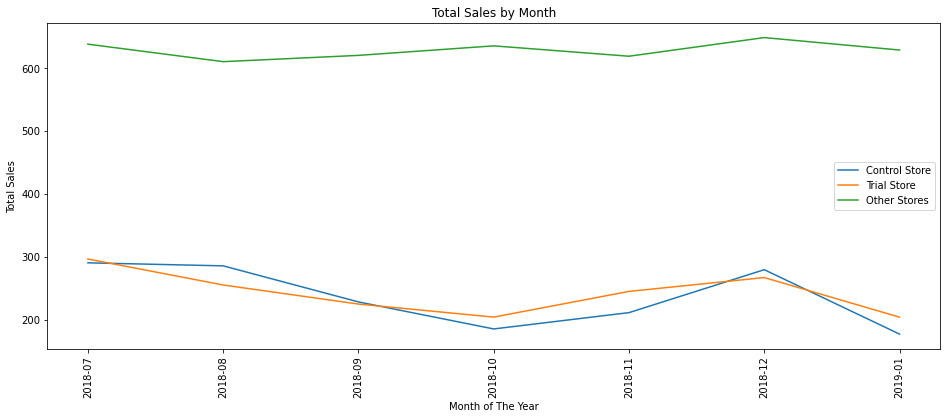

In [14]:
plt.figure(figsize=(16,6))
plt.plot(pivot_sales77)
plt.title('Total Sales by Month')
plt.xlabel('Month of The Year')
plt.ylabel('Total Sales')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 'center right')
plt.xticks(rotation=90);

In [15]:
store_customers = preTrial77[(preTrial77['store_type']!='Other Stores')].groupby(['store_type','month']).agg({'num_of_customers':'sum'}).reset_index()
pivot_customers77 = pd.pivot_table(store_customers, values = 'num_of_customers', index = 'month', columns ='store_type', aggfunc = 'sum')
otherCustPlot = preTrial77[preTrial77['store_type']=='Other Stores'].groupby('month').agg({'num_of_customers':'mean'})
otherCustPlot.rename(columns = {'num_of_customers': 'Other Stores'}, inplace = True)
otherCustPlot['Other Stores'] = round(otherCustPlot['Other Stores']).astype(int)
pivot_customers77 = pd.concat([pivot_customers77,otherCustPlot],axis=1)
pivot_customers77.index = pivot_customers77.index.astype(str)
pivot_customers77

,Control Store,Trial Store,Other Stores
month,,,
2018-07,51,51,72
2018-08,48,47,72
2018-09,42,42,70
2018-10,35,37,72
2018-11,40,41,71
2018-12,47,46,74
2019-01,35,35,71


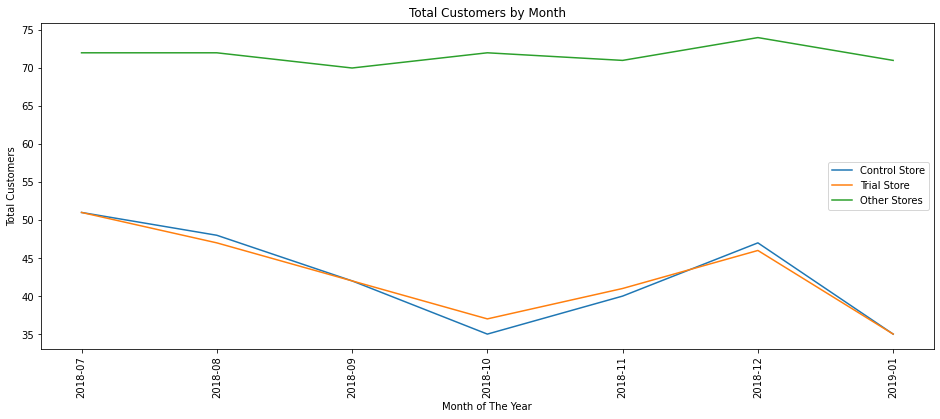

In [16]:
plt.figure(figsize=(16,6))
plt.plot(pivot_customers77)
plt.title('Total Customers by Month')
plt.xlabel('Month of The Year')
plt.ylabel('Total Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 'center right')
plt.xticks(rotation=90);

In [17]:
# Scale pre-trial control sales to match pre-trial trial store sales 
trial_store_sales = preTrial77[(preTrial77.store_nbr==trial_store)].monthly_sales.sum()
control_store_sales = preTrial77[(preTrial77.store_nbr==control_store)].monthly_sales.sum()
scalingFactorForControlSales = trial_store_sales / control_store_sales
scalingFactorForControlSales

1.023617303289553

In [18]:
# Apply the scaling factor
scaled_sales = metrics_df[metrics_df['store_nbr']==233][['month','monthly_sales']]
scaled_sales['scaled_control_sales'] = round(scaled_sales['monthly_sales'] * scalingFactorForControlSales,2)

# Calculate the percentage difference between scaled control sales and trial sales
trial_sales = metrics_df[metrics_df['store_nbr']==77][['month','monthly_sales']].rename(columns={'monthly_sales':'trial_sales'})
scaled_sales=scaled_sales.merge(trial_sales,on='month')
scaled_sales['percentageDiff'] = abs(scaled_sales['scaled_control_sales'] - scaled_sales['trial_sales']) / scaled_sales['scaled_control_sales']

scaled_sales.head()

,month,monthly_sales,scaled_control_sales,trial_sales,percentageDiff
0,2018-07,290.7,297.57,296.8,0.002588
1,2018-08,285.9,292.65,255.5,0.126943
2,2018-09,228.6,234.00,225.2,0.037607
3,2018-10,185.7,190.09,204.5,0.075806
4,2018-11,211.6,216.60,245.3,0.132502


In [19]:
# Null hypothesis : trial period is the same as the pre-trial period
# Take the standard deviation based on the scaled percentage difference in the pre-trial period 
stdDev = stdev(scaled_sales[scaled_sales['month'] < '2019-02']['percentageDiff'])
stdDev

0.04993490366659646

In [20]:
# Note that there are 8 months in the pre-trial period
# Hence 8 - 1 = 7 degrees of freedom
degreesOfFreedom = 7 

In [21]:
# Calculate the t-values for the trial months
# Hint: The test statistic here is (x - u)/standard deviation
scaled_sales['t_value'] = (scaled_sales['percentageDiff']-0)/stdDev

In [22]:
# Find the 95th percentile of the t distribution with the appropriate degrees of freedom
scipy.stats.t.isf(q=.05,df=degreesOfFreedom)

1.8945786050613054

In [23]:
scaled_sales[scaled_sales['t_value']>=scipy.stats.t.isf(q=.05,df=degreesOfFreedom)]

,month,monthly_sales,scaled_control_sales,trial_sales,percentageDiff,t_value
1,2018-08,285.9,292.65,255.5,0.126943,2.542179
4,2018-11,211.6,216.60,245.3,0.132502,2.653501
6,2019-01,177.5,181.69,204.4,0.124993,2.503121
8,2019-03,199.1,203.80,278.5,0.366536,7.340273
9,2019-04,158.6,162.35,263.5,0.623037,12.476977
10,2019-05,344.4,352.53,299.3,0.150994,3.023822
11,2019-06,221.0,226.22,264.7,0.170100,3.406433


We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

In [24]:
sales77_df = scaled_sales[['month','monthly_sales','trial_sales']].set_index('month')
sales77_df['5% CI'] = sales77_df['monthly_sales'] * (1 - stdDev*2)
sales77_df['95% CI'] = sales77_df['monthly_sales'] * (1 + stdDev*2)
sales77_df.rename(columns={'monthly_sales':'sales_store233','trial_sales':'sales_store77'},inplace=True)
sales77_df.index = sales77_df.index.astype(str)
sales77_df.head()

,sales_store233,sales_store77,5% CI,95% CI
month,,,,
2018-07,290.7,296.8,261.667847,319.732153
2018-08,285.9,255.5,257.347222,314.452778
2018-09,228.6,225.2,205.769762,251.430238
2018-10,185.7,204.5,167.154177,204.245823
2018-11,211.6,245.3,190.467549,232.732451


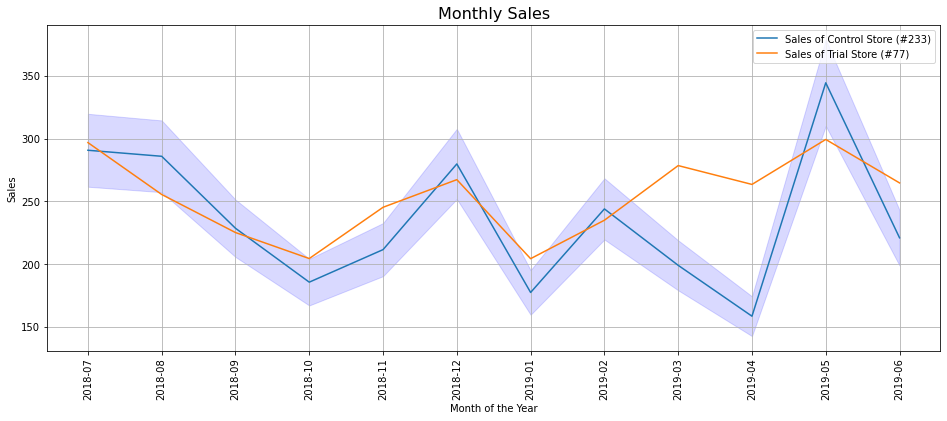

In [25]:
plt.figure(figsize=(16,6))
plt.plot(sales77_df['sales_store233'], label='Sales of Control Store (#233)')
plt.plot(sales77_df['sales_store77'], label='Sales of Trial Store (#77)')
# plt.plot(sales77_df['5% CI'],'--')
# plt.plot(sales77_df['95% CI'],'--')
plt.xticks(rotation=90);

# Set graph title and axis title
plt.title('Monthly Sales',fontsize=16)
plt.xlabel('Month of the Year')
plt.ylabel('Sales')

# Highlight confidence interval
plt.fill_between(sales77_df.index,  sales77_df['5% CI'],  sales77_df['95% CI'],  color='blue', alpha=.15)

# Set legend
plt.legend(loc = 'upper right')
plt.grid();

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

In [26]:
# Compute a scaling factor to align control store customer counts to the trial store.
trial_store_customers = preTrial77[(preTrial77.store_nbr==trial_store)].num_of_customers.sum()
control_store_customers = preTrial77[(preTrial77.store_nbr==control_store)].num_of_customers.sum()
scalingFactorForControlCustomers = trial_store_customers / control_store_customers

scaled_customers = metrics_df[metrics_df['store_nbr']==233][['month','num_of_customers']]
scaled_customers['scaled_control_customers'] = round(scaled_customers['num_of_customers'] * scalingFactorForControlCustomers,2)

# Calculate the percentage difference between scaled control sales and trial sales
trial_customers = metrics_df[metrics_df['store_nbr']==77][['month','num_of_customers']].rename(columns={'num_of_customers':'trial_customers'})
scaled_customers = scaled_customers.merge(trial_customers,on='month')
scaled_customers['percentageDiff'] = abs(scaled_customers['scaled_control_customers'] - scaled_customers['trial_customers']) / scaled_customers['scaled_control_customers']

stdDev = stdev(scaled_customers[scaled_sales['month'] < '2019-02']['percentageDiff'])
scaled_customers['t_value'] = (scaled_customers['percentageDiff']-0)/stdDev
scaled_customers[scaled_customers['t_value']>=scipy.stats.t.isf(q=.05,df=degreesOfFreedom)]

,month,num_of_customers,scaled_control_customers,trial_customers,percentageDiff,t_value
3,2018-10,35,35.12,37,0.053531,2.938591
8,2019-03,40,40.13,50,0.245951,13.501554
9,2019-04,30,30.10,47,0.561462,30.821656
10,2019-05,57,57.19,55,0.038293,2.102131


In [27]:
customers77_df = scaled_customers[['month','num_of_customers','trial_customers']].set_index('month')
customers77_df['5% CI'] = customers77_df['num_of_customers'] * (1 - stdDev*2)
customers77_df['95% CI'] = customers77_df['num_of_customers'] * (1 + stdDev*2)
customers77_df.rename(columns={'num_of_customers':'customers_store233','trial_customers':'customers_store77'},inplace=True)
customers77_df.index = sales77_df.index.astype(str)
customers77_df.head()

,customers_store233,customers_store77,5% CI,95% CI
month,,,,
2018-07,51,51,49.141920,52.858080
2018-08,48,47,46.251219,49.748781
2018-09,42,42,40.469816,43.530184
2018-10,35,37,33.724847,36.275153
2018-11,40,41,38.542682,41.457318


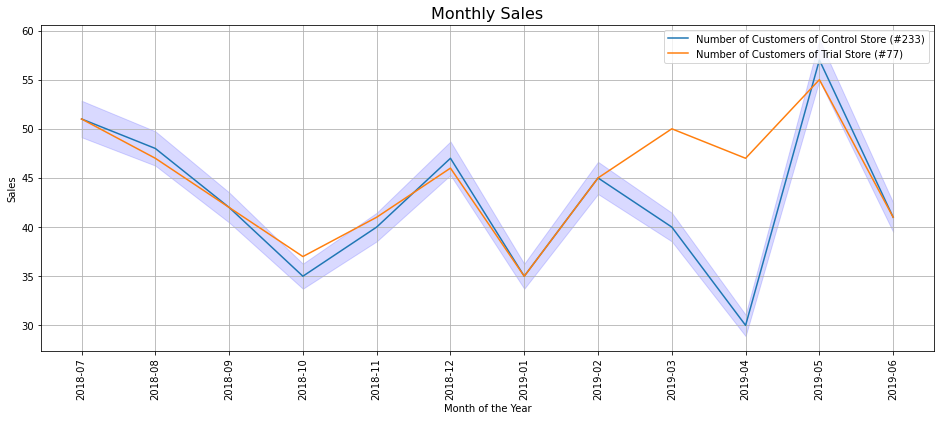

In [28]:
plt.figure(figsize=(16,6))
plt.plot(customers77_df['customers_store233'], label='Number of Customers of Control Store (#233)')
plt.plot(customers77_df['customers_store77'], label='Number of Customers of Trial Store (#77)')

# Highlight confidence interval
plt.fill_between(customers77_df.index, customers77_df['5% CI'], customers77_df['95% CI'], color='blue', alpha=.15)

# Set graph title and axis title
plt.title('Monthly Sales',fontsize=16)
plt.xlabel('Month of the Year')
plt.xticks(rotation=90)
plt.ylabel('Sales')
plt.legend(loc = 'upper right')
plt.grid();

# Trial Store 86

In [29]:
# Compare monthly sales and number of customers of each control store with trial store 86
preTrial86 = metrics_df[metrics_df['month'] < '2019-02']

# in terms of correlation 
trial_store = 86
corr_86Sales = cal_correlation(preTrial86, 'monthly_sales', trial_store)
corr_86Customers = cal_correlation(preTrial86, 'num_of_customers', trial_store)

# in terms of absolute difference 
mag_86Sales = abs_diff(preTrial86, 'monthly_sales', trial_store)
mag_86Customers = abs_diff(preTrial86, 'num_of_customers', trial_store)

In [30]:
score_86Sales = pd.merge(corr_86Sales, mag_86Sales, on=['Trial Store', 'Control Store']).rename(columns={'Correlation':'corr_sales','Magnitude':'mag_sales'})
score_86Cust = pd.merge(corr_86Customers, mag_86Customers, on=['Trial Store', 'Control Store']).rename(columns={'Correlation':'corr_customers','Magnitude':'mag_customers'})
score_86Trial = pd.merge(score_86Sales, score_86Cust, on=['Trial Store', 'Control Store'])

# Consider it more important for the trend of the drivers to be similar
# increase the weight of the correlation score
score_86Trial['score_sales'] = 0.5 * score_86Trial['corr_sales'] + 0.5 * score_86Trial['mag_sales']
score_86Trial['score_customers'] = 0.5 * score_86Trial['corr_customers'] + 0.5 * score_86Trial['mag_customers']
score_86Trial['overall_score'] = (score_86Trial['score_sales']+score_86Trial['score_customers'])/2
score_86Trial.sort_values('overall_score',ascending=False).head()

,Trial Store,Control Store,corr_sales,mag_sales,corr_customers,mag_customers,score_sales,score_customers,overall_score
147,86.0,155.0,0.877882,0.738330,0.942876,0.523810,0.808106,0.733343,0.770724
102,86.0,109.0,0.788300,0.605940,0.770778,0.714286,0.697120,0.742532,0.719826
107,86.0,114.0,0.734415,0.528371,0.855339,0.471429,0.631393,0.663384,0.647389
213,86.0,225.0,0.617533,0.586150,0.733791,0.634921,0.601841,0.684356,0.643099
130,86.0,138.0,0.759864,0.426729,0.749701,0.571429,0.593296,0.660565,0.626930


Looks like store 155 will be a control store for trial store 86.

In [31]:
# check visually if the drivers are indeed similar in the period before the trial.
# Conduct visual checks on customer count trends by comparing the trial store to the control store and other stores.
control_store = 155
store_type = []

for i in preTrial86['store_nbr']:
    if i == trial_store:
        store_type.append('Trial Store')
    elif i == control_store:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

preTrial86['store_type'] = store_type
preTrial86.sample(5)

,store_nbr,month,monthly_sales,num_of_customers,num_of_txn,prod_qty,txn_per_customer,qty_per_customer,avg_price_per_unit,store_type
2158,185,2018-12,206.2,40,42,58,1.050000,1.450000,3.555172,Other Stores
870,75,2018-10,1255.6,124,145,288,1.169355,2.322581,4.359722,Other Stores
537,47,2019-01,389.8,57,59,111,1.035088,1.947368,3.511712,Other Stores
1811,156,2019-01,1199.0,120,167,340,1.391667,2.833333,3.526471,Other Stores
2728,235,2018-12,554.6,59,63,126,1.067797,2.135593,4.401587,Other Stores


In [32]:
store_sales = preTrial86[(preTrial86['store_type']!='Other Stores')].groupby(['store_type','month']).agg({'monthly_sales':'sum'}).reset_index()
pivot_sales86 = pd.pivot_table(store_sales, values = 'monthly_sales', index = 'month', columns ='store_type', aggfunc = 'sum')
otherSalesPlot = preTrial86.loc[preTrial86['store_type'] == 'Other Stores', ['month', 'monthly_sales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('month').monthly_sales.mean())
otherSalesPlot.rename(columns = {'monthly_sales': 'Other Stores'}, inplace = True)
otherSalesPlot['Other Stores'] = round(otherSalesPlot['Other Stores'],2)
pivot_sales86 = pd.concat([pivot_sales86,otherSalesPlot],axis=1)
pivot_sales86.index = pivot_sales86.index.astype(str)
pivot_sales86

,Control Store,Trial Store,Other Stores
month,,,
2018-07,924.6,892.20,633.24
2018-08,782.7,764.05,606.33
2018-09,1014.4,914.60,614.48
2018-10,963.8,948.40,629.42
2018-11,898.8,918.00,613.59
2018-12,849.8,841.20,644.02
2019-01,874.6,841.40,623.51


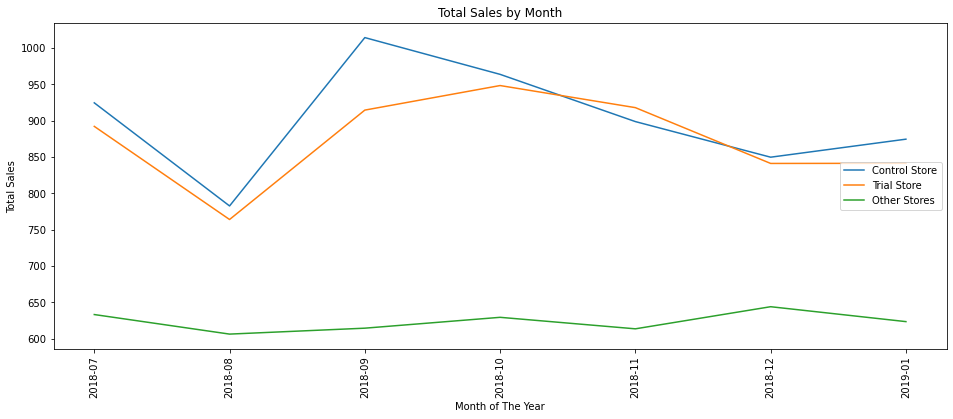

In [33]:
plt.figure(figsize=(16,6))
plt.plot(pivot_sales86)
plt.title('Total Sales by Month')
plt.xlabel('Month of The Year')
plt.ylabel('Total Sales')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 'center right')
plt.xticks(rotation=90);

Great, sales are trending in a similar way.

In [34]:
store_customers = preTrial86[(preTrial86['store_type']!='Other Stores')].groupby(['store_type','month']).agg({'num_of_customers':'sum'}).reset_index()
pivot_customers86 = pd.pivot_table(store_customers, values = 'num_of_customers', index = 'month', columns ='store_type', aggfunc = 'sum')
otherCustPlot = preTrial86[preTrial86['store_type']=='Other Stores'].groupby('month').agg({'num_of_customers':'mean'})
otherCustPlot.rename(columns = {'num_of_customers': 'Other Stores'}, inplace = True)
otherCustPlot['Other Stores'] = round(otherCustPlot['Other Stores']).astype(int)
pivot_customers86 = pd.concat([pivot_customers86,otherCustPlot],axis=1)
pivot_customers86.index = pivot_customers86.index.astype(str)
pivot_customers86

,Control Store,Trial Store,Other Stores
month,,,
2018-07,101,99,72
2018-08,91,94,72
2018-09,103,103,70
2018-10,108,109,71
2018-11,101,100,70
2018-12,97,98,73
2019-01,96,94,71


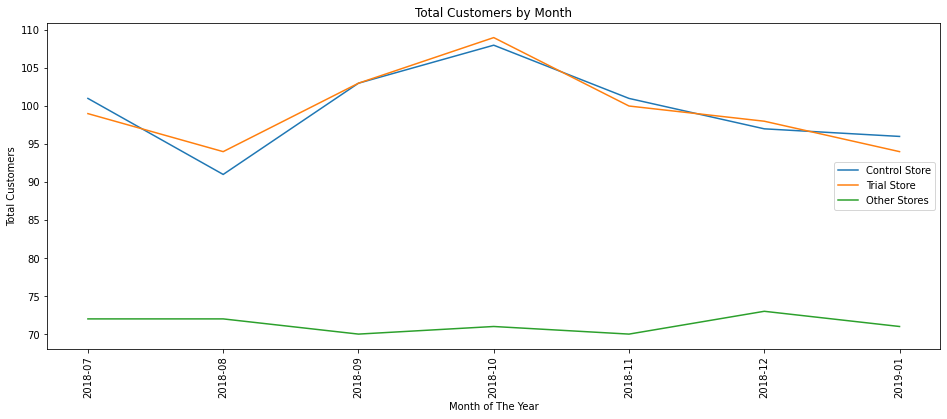

In [35]:
plt.figure(figsize=(16,6))
plt.plot(pivot_customers86)
plt.title('Total Customers by Month')
plt.xlabel('Month of The Year')
plt.ylabel('Total Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 'center right')
plt.xticks(rotation=90);

Good, the trend in number of customers is also similar.

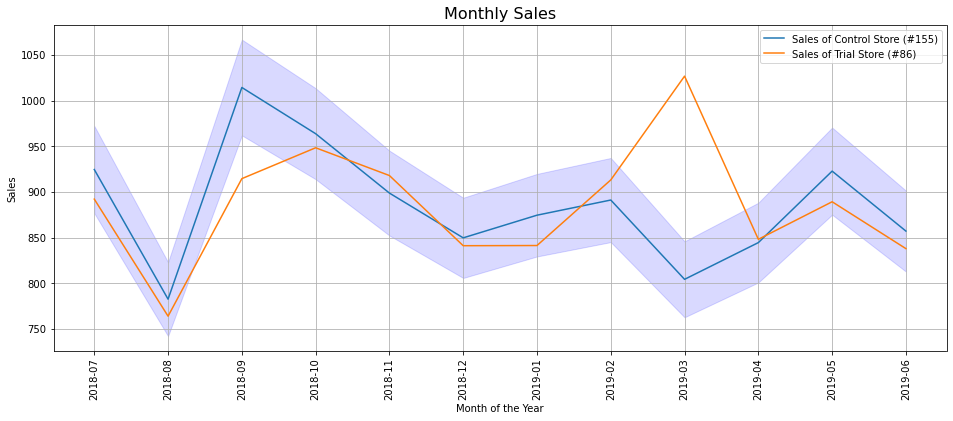

In [36]:
# Scale pre-trial control sales to match pre-trial trial store sales 
trial_store_sales = preTrial86[(preTrial86.store_nbr==trial_store)].monthly_sales.sum()
control_store_sales = preTrial86[(preTrial86.store_nbr==control_store)].monthly_sales.sum()
scalingFactorForControlSales = trial_store_sales / control_store_sales

# Apply the scaling factor
scaled_sales = metrics_df[metrics_df['store_nbr']==control_store][['month','monthly_sales']]
scaled_sales['scaled_control_sales'] = round(scaled_sales['monthly_sales'] * scalingFactorForControlSales,2)

# Calculate the percentage difference between scaled control sales and trial sales
trial_sales = metrics_df[metrics_df['store_nbr']==trial_store][['month','monthly_sales']].rename(columns={'monthly_sales':'trial_sales'})
scaled_sales=scaled_sales.merge(trial_sales,on='month')
scaled_sales['percentageDiff'] = abs(scaled_sales['scaled_control_sales'] - scaled_sales['trial_sales']) / scaled_sales['scaled_control_sales']

stdDev = stdev(scaled_sales[scaled_sales['month'] < '2019-02']['percentageDiff'])

scaled_sales['t_value'] = (scaled_sales['percentageDiff']-0)/stdDev

sales86_df = scaled_sales[['month','monthly_sales','trial_sales']].set_index('month')
sales86_df['5% CI'] = sales86_df['monthly_sales'] * (1 - stdDev*2)
sales86_df['95% CI'] = sales86_df['monthly_sales'] * (1 + stdDev*2)
sales86_df.rename(columns={'monthly_sales':'sales_store155','trial_sales':'sales_store86'},inplace=True)
sales86_df.index = sales86_df.index.astype(str)

plt.figure(figsize=(16,6))
plt.plot(sales86_df['sales_store155'], label='Sales of Control Store (#155)')
plt.plot(sales86_df['sales_store86'], label='Sales of Trial Store (#86)')
plt.xticks(rotation=90)

plt.fill_between(sales86_df.index,  sales86_df['5% CI'],  sales86_df['95% CI'],  color='blue', alpha=.15)

# Set graph title and axis title
plt.title('Monthly Sales',fontsize=16)
plt.xlabel('Month of the Year')
plt.ylabel('Sales')
plt.legend(loc = 'upper right')
plt.grid();

The results show that the trial in store 86 is not significantly different to its control store in the trial period as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months.


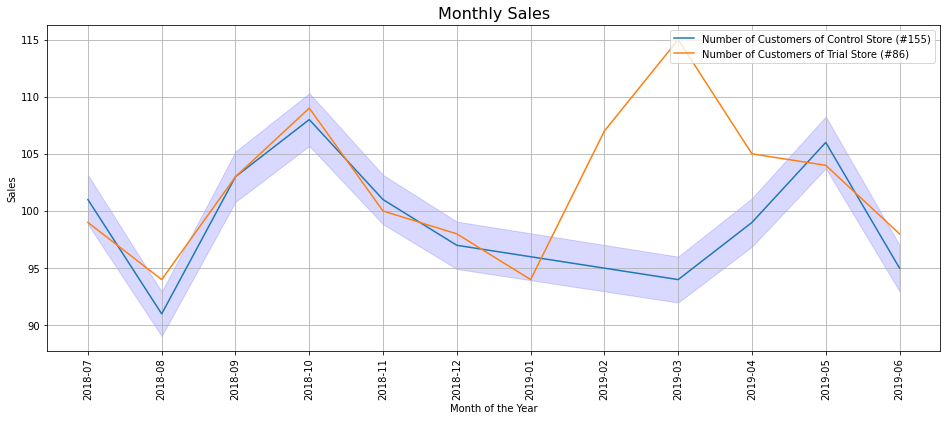

In [37]:
# Compute a scaling factor to align control store customer counts to the trial store.
trial_store_customers = preTrial86[(preTrial86.store_nbr==trial_store)].num_of_customers.sum()
control_store_customers = preTrial86[(preTrial86.store_nbr==control_store)].num_of_customers.sum()
scalingFactorForControlCustomers = trial_store_customers / control_store_customers

scaled_customers = metrics_df[metrics_df['store_nbr']==control_store][['month','num_of_customers']]
scaled_customers['scaled_control_customers'] = round(scaled_customers['num_of_customers'] * scalingFactorForControlCustomers,2)

# Calculate the percentage difference between scaled control sales and trial sales
trial_customers = metrics_df[metrics_df['store_nbr']==trial_store][['month','num_of_customers']].rename(columns={'num_of_customers':'trial_customers'})
scaled_customers = scaled_customers.merge(trial_customers,on='month')
scaled_customers['percentageDiff'] = abs(scaled_customers['scaled_control_customers'] - scaled_customers['trial_customers']) / scaled_customers['scaled_control_customers']

stdDev = stdev(scaled_customers[scaled_sales['month'] < '2019-02']['percentageDiff'])
scaled_customers['t_value'] = (scaled_customers['percentageDiff']-0)/stdDev

customers86_df = scaled_customers[['month','num_of_customers','trial_customers']].set_index('month')
customers86_df['5% CI'] = customers86_df['num_of_customers'] * (1 - stdDev*2)
customers86_df['95% CI'] = customers86_df['num_of_customers'] * (1 + stdDev*2)
customers86_df.rename(columns={'num_of_customers':'customers_store155','trial_customers':'customers_store86'},inplace=True)
customers86_df.index = sales86_df.index.astype(str)

plt.figure(figsize=(16,6))
plt.plot(customers86_df['customers_store155'], label='Number of Customers of Control Store (#155)')
plt.plot(customers86_df['customers_store86'], label='Number of Customers of Trial Store (#86)')

# Highlight confidence interval
plt.fill_between(customers86_df.index, customers86_df['5% CI'], customers86_df['95% CI'], color='blue', alpha=.15)

# Set graph title and axis title
plt.title('Monthly Sales',fontsize=16)
plt.xlabel('Month of the Year')
plt.xticks(rotation=90)
plt.ylabel('Sales')
plt.legend(loc = 'upper right')
plt.grid();

It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.

# Trial Store 88

In [38]:
# Compare monthly sales and number of customers of each control store with trial store 88
preTrial88 = metrics_df[metrics_df['month'] < '2019-02']

# in terms of correlation 
trial_store = 88
corr_88Sales = cal_correlation(preTrial88, 'monthly_sales', trial_store)
corr_88Custs = cal_correlation(preTrial88, 'num_of_customers', trial_store)

# in terms of absolute difference 
mag_88Sales = abs_diff(preTrial88, 'monthly_sales', trial_store)
mag_88Custs = abs_diff(preTrial88, 'num_of_customers', trial_store)

In [39]:
score_88Sales = pd.merge(corr_88Sales, mag_88Sales, on=['Trial Store', 'Control Store']).rename(columns={'Correlation':'corr_sales','Magnitude':'mag_sales'})
score_88Cust = pd.merge(corr_88Custs, mag_88Custs, on=['Trial Store', 'Control Store']).rename(columns={'Correlation':'corr_customers','Magnitude':'mag_customers'})
score_88Trial = pd.merge(score_88Sales, score_88Cust, on=['Trial Store', 'Control Store'])

# Consider it more important for the trend of the drivers to be similar
# increase the weight of the correlation score
score_88Trial['score_sales'] = 0.5 * score_88Trial['corr_sales'] + 0.5 * score_88Trial['mag_sales']
score_88Trial['score_customers'] = 0.5 * score_88Trial['corr_customers'] + 0.5 * score_88Trial['mag_customers']
score_88Trial['overall_score'] = (score_88Trial['score_sales']+score_88Trial['score_customers'])/2
score_88Trial.sort_values('overall_score',ascending=False).head()

,Trial Store,Control Store,corr_sales,mag_sales,corr_customers,mag_customers,score_sales,score_customers,overall_score
170,88.0,178.0,0.731857,0.569749,0.939466,0.476190,0.650803,0.707828,0.679316
12,88.0,14.0,0.698557,0.593571,0.942976,0.428571,0.646064,0.685774,0.665919
126,88.0,134.0,0.864293,0.685875,0.508880,0.571429,0.775084,0.540154,0.657619
225,88.0,237.0,0.308479,0.595469,0.947326,0.607143,0.451974,0.777235,0.614604
179,88.0,187.0,0.599076,0.634428,0.671264,0.517857,0.616752,0.594560,0.605656


In [40]:
# check visually if the drivers are indeed similar in the period before the trial.
# Conduct visual checks on customer count trends by comparing the trial store to the control store and other stores.
control_store = 237
store_type = []

for i in preTrial88['store_nbr']:
    if i == trial_store:
        store_type.append('Trial Store')
    elif i == control_store:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

preTrial88['store_type'] = store_type
preTrial88.sample(5)

,store_nbr,month,monthly_sales,num_of_customers,num_of_txn,prod_qty,txn_per_customer,qty_per_customer,avg_price_per_unit,store_type
2462,213,2018-09,1079.2,123,154,310,1.252033,2.520325,3.481290,Other Stores
2082,179,2018-08,961.9,106,143,275,1.349057,2.594340,3.497818,Other Stores
2664,230,2018-08,1010.7,115,153,283,1.330435,2.460870,3.571378,Other Stores
41,4,2018-12,1185.6,104,133,266,1.278846,2.557692,4.457143,Other Stores
1638,142,2018-08,506.6,60,65,115,1.083333,1.916667,4.405217,Other Stores


In [41]:
store_sales = preTrial88[(preTrial88['store_type']!='Other Stores')].groupby(['store_type','month']).agg({'monthly_sales':'sum'}).reset_index()
pivot_sales88 = pd.pivot_table(store_sales, values = 'monthly_sales', index = 'month', columns ='store_type', aggfunc = 'sum')
otherSalesPlot = preTrial88.loc[preTrial88['store_type'] == 'Other Stores', ['month', 'monthly_sales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('month').monthly_sales.mean())
otherSalesPlot.rename(columns = {'monthly_sales': 'Other Stores'}, inplace = True)
otherSalesPlot['Other Stores'] = round(otherSalesPlot['Other Stores'],2)
pivot_sales88 = pd.concat([pivot_sales88,otherSalesPlot],axis=1)
pivot_sales88.index = pivot_sales86.index.astype(str)
pivot_sales88

,Control Store,Trial Store,Other Stores
month,,,
2018-07,1448.4,1310.0,629.59
2018-08,1367.8,1323.8,601.89
2018-09,1322.2,1423.0,611.32
2018-10,1348.3,1352.4,626.36
2018-11,1397.6,1382.8,609.86
2018-12,1265.0,1325.2,640.53
2019-01,1219.7,1266.4,620.53


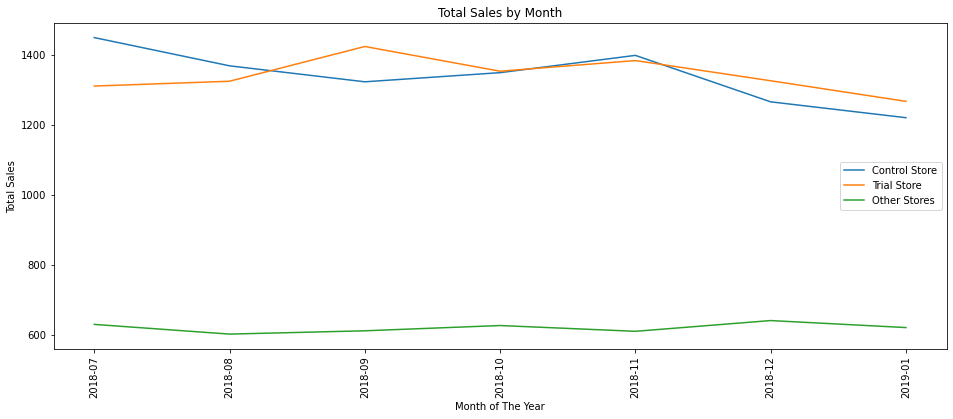

In [42]:
plt.figure(figsize=(16,6))
plt.plot(pivot_sales88)
plt.title('Total Sales by Month')
plt.xlabel('Month of The Year')
plt.ylabel('Total Sales')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 'center right')
plt.xticks(rotation=90);

In [43]:
store_customers = preTrial88[(preTrial88['store_type']!='Other Stores')].groupby(['store_type','month']).agg({'num_of_customers':'sum'}).reset_index()
pivot_customers88 = pd.pivot_table(store_customers, values = 'num_of_customers', index = 'month', columns ='store_type', aggfunc = 'sum')
otherCustPlot = preTrial88[preTrial88['store_type']=='Other Stores'].groupby('month').agg({'num_of_customers':'mean'})
otherCustPlot.rename(columns = {'num_of_customers': 'Other Stores'}, inplace = True)
otherCustPlot['Other Stores'] = round(otherCustPlot['Other Stores']).astype(int)
pivot_customers88 = pd.concat([pivot_customers88,otherCustPlot],axis=1)
pivot_customers88.index = pivot_customers88.index.astype(str)
pivot_customers88

,Control Store,Trial Store,Other Stores
month,,,
2018-07,128,129,72
2018-08,135,131,71
2018-09,126,124,69
2018-10,123,123,71
2018-11,132,130,70
2018-12,124,126,73
2019-01,117,117,71


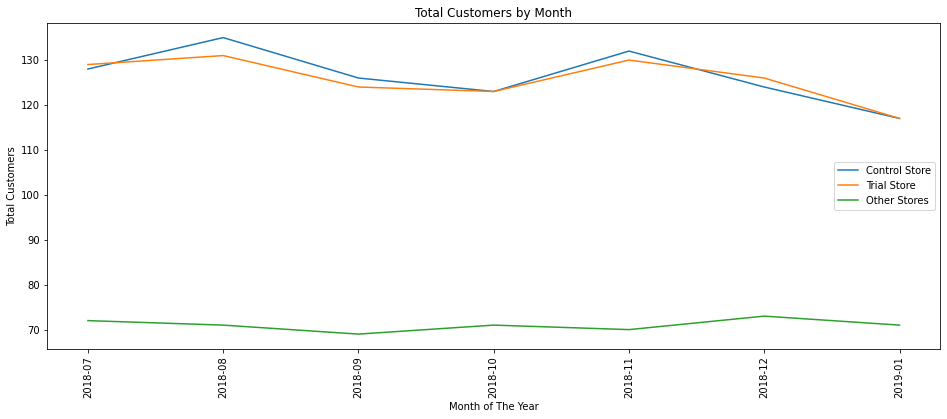

In [44]:
plt.figure(figsize=(16,6))
plt.plot(pivot_customers88)
plt.title('Total Customers by Month')
plt.xlabel('Month of The Year')
plt.ylabel('Total Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 'center right')
plt.xticks(rotation=90);

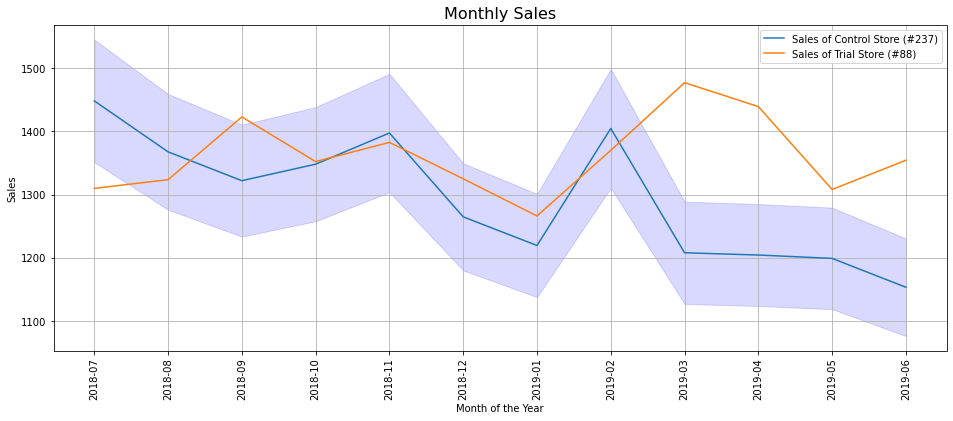

In [45]:
# Scale pre-trial control sales to match pre-trial trial store sales 
trial_store_sales = preTrial88[(preTrial88.store_nbr==trial_store)].monthly_sales.sum()
control_store_sales = preTrial88[(preTrial88.store_nbr==control_store)].monthly_sales.sum()
scalingFactorForControlSales = trial_store_sales / control_store_sales

# Apply the scaling factor
scaled_sales = metrics_df[metrics_df['store_nbr']==control_store][['month','monthly_sales']]
scaled_sales['scaled_control_sales'] = round(scaled_sales['monthly_sales'] * scalingFactorForControlSales,2)

# Calculate the percentage difference between scaled control sales and trial sales
trial_sales = metrics_df[metrics_df['store_nbr']==trial_store][['month','monthly_sales']].rename(columns={'monthly_sales':'trial_sales'})
scaled_sales=scaled_sales.merge(trial_sales,on='month')
scaled_sales['percentageDiff'] = abs(scaled_sales['scaled_control_sales'] - scaled_sales['trial_sales']) / scaled_sales['scaled_control_sales']

stdDev = stdev(scaled_sales[scaled_sales['month'] < '2019-02']['percentageDiff'])

scaled_sales['t_value'] = (scaled_sales['percentageDiff']-0)/stdDev

sales88_df = scaled_sales[['month','monthly_sales','trial_sales']].set_index('month')
sales88_df['5% CI'] = sales88_df['monthly_sales'] * (1 - stdDev*2)
sales88_df['95% CI'] = sales88_df['monthly_sales'] * (1 + stdDev*2)
sales88_df.rename(columns={'monthly_sales':'sales_store237','trial_sales':'sales_store88'},inplace=True)
sales88_df.index = sales88_df.index.astype(str)

plt.figure(figsize=(16,6))
plt.plot(sales88_df['sales_store237'], label='Sales of Control Store (#237)')
plt.plot(sales88_df['sales_store88'], label='Sales of Trial Store (#88)')
plt.xticks(rotation=90)

plt.fill_between(sales88_df.index,  sales88_df['5% CI'],  sales88_df['95% CI'],  color='blue', alpha=.15)

# Set graph title and axis title
plt.title('Monthly Sales',fontsize=16)
plt.xlabel('Month of the Year')
plt.ylabel('Sales')
plt.legend(loc = 'upper right')
plt.grid();

The results show that the trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.

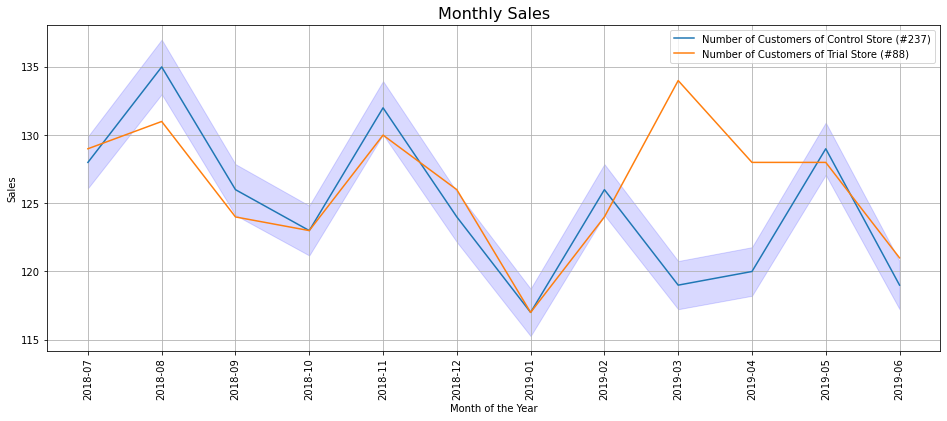

In [46]:
# Compute a scaling factor to align control store customer counts to the trial store.
trial_store_customers = preTrial88[(preTrial88.store_nbr==trial_store)].num_of_customers.sum()
control_store_customers = preTrial88[(preTrial88.store_nbr==control_store)].num_of_customers.sum()
scalingFactorForControlCustomers = trial_store_customers / control_store_customers

scaled_customers = metrics_df[metrics_df['store_nbr']==control_store][['month','num_of_customers']]
scaled_customers['scaled_control_customers'] = round(scaled_customers['num_of_customers'] * scalingFactorForControlCustomers,2)

# Calculate the percentage difference between scaled control sales and trial sales
trial_customers = metrics_df[metrics_df['store_nbr']==trial_store][['month','num_of_customers']].rename(columns={'num_of_customers':'trial_customers'})
scaled_customers = scaled_customers.merge(trial_customers,on='month')
scaled_customers['percentageDiff'] = abs(scaled_customers['scaled_control_customers'] - scaled_customers['trial_customers']) / scaled_customers['scaled_control_customers']

stdDev = stdev(scaled_customers[scaled_sales['month'] < '2019-02']['percentageDiff'])
scaled_customers['t_value'] = (scaled_customers['percentageDiff']-0)/stdDev

customers88_df = scaled_customers[['month','num_of_customers','trial_customers']].set_index('month')
customers88_df['5% CI'] = customers88_df['num_of_customers'] * (1 - stdDev*2)
customers88_df['95% CI'] = customers88_df['num_of_customers'] * (1 + stdDev*2)
customers88_df.rename(columns={'num_of_customers':'customers_store237','trial_customers':'customers_store88'},inplace=True)
customers88_df.index = sales88_df.index.astype(str)

plt.figure(figsize=(16,6))
plt.plot(customers88_df['customers_store237'], label='Number of Customers of Control Store (#237)')
plt.plot(customers88_df['customers_store88'], label='Number of Customers of Trial Store (#88)')

# Highlight confidence interval
plt.fill_between(customers88_df.index, customers88_df['5% CI'], customers88_df['95% CI'], color='blue', alpha=.15)

# Set graph title and axis title
plt.title('Monthly Sales',fontsize=16)
plt.xlabel('Month of the Year')
plt.xticks(rotation=90)
plt.ylabel('Sales')
plt.legend(loc = 'upper right')
plt.grid();

Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

# Summary 
The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the three trial months but this is not the case for trial store 86. We can check with the client if the implementation of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales. 